# Лабораторная работа № 4.1
## "Определение энергии $\alpha$-частиц по величине их пробега в воздухе"

Измеряется пробег $\alpha$-частиц в воздухе двумя способами $-$ с помощью торцевого счетчика Гейгера и сцинтилляционного счетчика, $-$ и по полученным величинам определяется их энергия.

In [213]:
WORKING_DIRECTORY = 'alekseik1-642'
RA_FILE = 'radium.csv'
U_FILE = 'uran.csv'
PU_FILE = 'pu.csv'
AM_TH_FILE = 'Am+Th.csv'
# TODO: поменяйте на свой
HEADER_NUMBER = 21

In [214]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

In [215]:
def read_table_and_time(path):
    df = pd.read_csv(
        path, 
        delimiter=';')
    # Найдем время
    time = df[df['Unnamed: 0'] == 'LTime'].iloc[-1, 1]
    # Возьмем нужные данные
    ind = df[df['Unnamed: 0'] == 'Channel'].index[0]
    df.columns = df.iloc[ind]
    df = df.iloc[ind+1:]
    # Обнулим индексы
    df.reset_index(drop=True, inplace=True)
    # Приведем к численному типу
    df = df.apply(pd.to_numeric)
    return df, float(time)

### Градуировка по $_{\phantom{2}88}^{226}Ra$

In [216]:
ra_df, ra_time = read_table_and_time(os.path.join(WORKING_DIRECTORY, 
                                                  RA_FILE))
ra_df.head()

20,Channel,Value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [217]:
x_data = ra_df['Channel']
y_data = ra_df['Value']
#plt.plot(x_values, y_values)
#plt.show()

In [340]:
def plot_data_optimized(x_values, y_values, fig=None, axes=None,
                        title=r'Graph', x_label=r'X', y_label=r'Y', 
                        save_to=False, threshold=0.01):
    '''
    Умное построение:
    1) Убираются данные, похожие на шум (те, чье значение < 1% от максимального)
    '''
    if fig is None or axes is None:
        fig, axes = plt.subplots(figsize=(16, 9))
    
    max_y, min_y = np.max(y_values), np.min(y_values)
    threshold *= (max_y-min_y)
    x_values, y_values = (x_values[y_values >= threshold], 
                          y_values[y_values >= threshold])
    
    axes.plot(x_values, y_values)
    axes.grid(True)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)
    
    # Сохраним
    if save_to:
        fig.savefig(save_to)
    return fig, axes

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


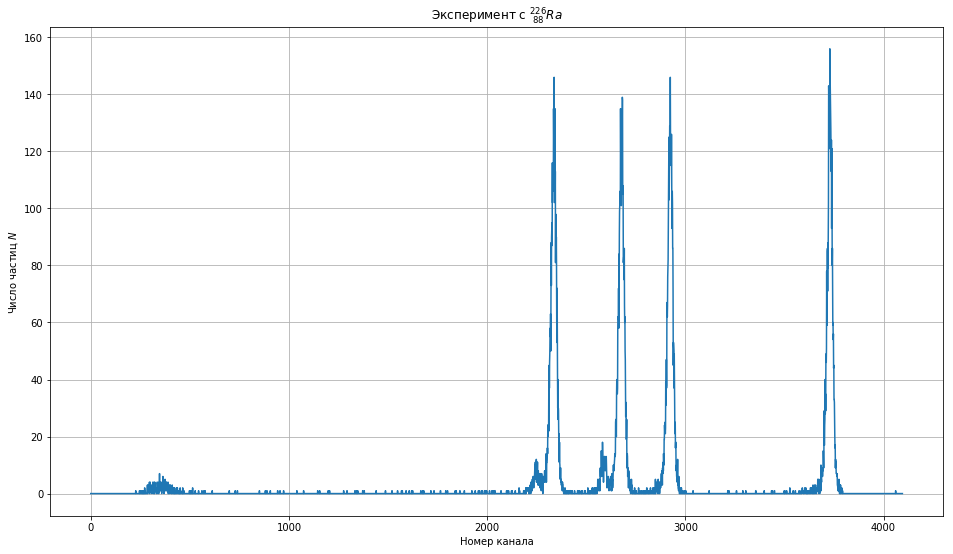

In [341]:
plot_data_optimized(x_values=x_data, y_values=y_data, threshold=0,
                    title=r'Эксперимент с $^{226}_{\,\,88}Ra$', 
                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                    save_to='out1.pdf')[0].show()

Попытаемся аппросимировать пики гауссианой

In [384]:
# Сначала нам надо определять пределы аппроксимирования
def find_gaus_interval(x_data, y_data):
    # Будем полагать, что пик начинается там, где данные выше матожидания
    mean = y_data.mean()
    x_peaks, y_peaks = x_data[y_data > mean], y_data[y_data > mean]
    # Теперь из этот массив надо разделить на отдельные пики
    # Как это сделать -- отдельный вопрос анализа данных.
    # Я считаю, что можно определить начало и конец пика 
    # по изменению направления мототонности данных
    def is_growing(data):
        return np.append(np.diff(data) > 0, [True])
    def is_descending(data):
        return np.append(np.diff(data) < 0, True)
    return x_peaks[is_growing(y_peaks)], y_peaks[is_growing(y_peaks)]

In [443]:
from scipy.optimize import curve_fit
def fit_with_gauss(x_data, y_data, y_error=None, initial_guess=[1, 1, 1]):
    #def find_optimal_function(data, functions, y_data='N', x_data='LL', y_error=None):
    if y_error is None:
        #y_error = y_data + '_error'
        y_error = np.zeros(len(y_data))
    #  Подготим все к подгону! 1) Вычтем минимальное значение;
    # 2) поделим X на максимальный из X;
    y_data = y_data.copy()
    x_data = x_data.copy()
    min_y = np.min(y_data)
    y_data -= min_y
    max_x = np.max(x_data)
    x_data /= max_x
    func = lambda x, a, mu, sigma: a*np.exp(-(x-mu)**2/(2*sigma**2))
    popt, pcov = curve_fit(func, x_data, y_data, maxfev=100000, p0=initial_guess)
    # Преобразуем оптимальные параметры обратно
    popt[1] *= max_x
    popt[2] *= max_x
    return lambda x: (func(x , *popt) + min_y), popt

In [535]:
# TODO: замените на свои
# Я очень хорошо угадал свои интервалы!
peaks = [
    # Мелкий пик
    (2200, 2290),
    # Большой пик
    (2280, 2400),
    # Мелкий пик
    (2550, 2630),
    # Большой пик
    (2500, 2730),
    # Большой пик
    (2850, 2990),
    # Большой пик
    (3640, 3810)
]

In [536]:
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

In [537]:
f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


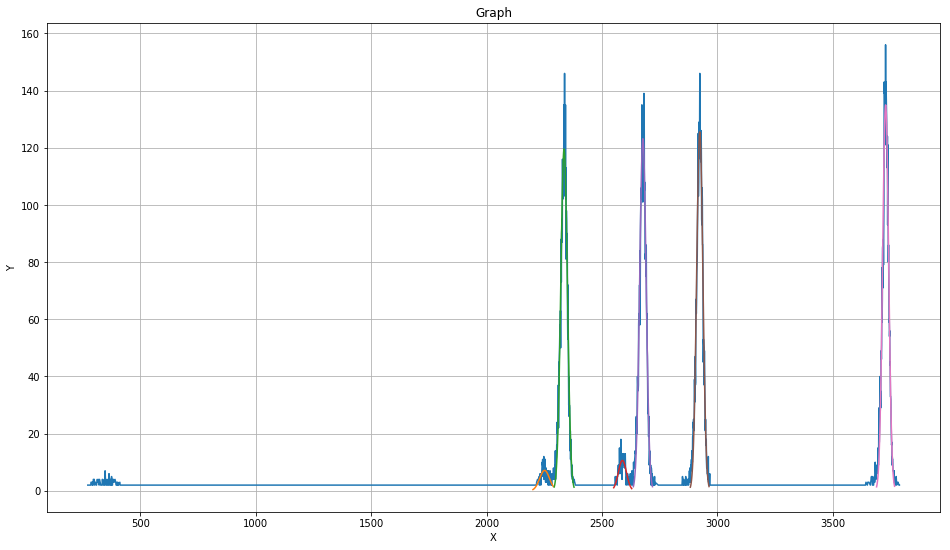

In [538]:
fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes)
fig.savefig('out1.pdf')
fig.show()

Имеем хорошие пики! Теперь пора на них садиться...